In [18]:
import torch
import torchvision
from torchvision import datasets
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from torch.utils.data import Subset
import matplotlib.pyplot as plt
from torchmetrics.classification import MulticlassAccuracy
from tqdm import tqdm

# Load data

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [5]:
from utils import CustomDataset

In [6]:
DATA_PATH = "../data/trafic_32"
dataset = datasets.ImageFolder(root=DATA_PATH)
custom_dataset = CustomDataset(dataset, transform=transforms.ToTensor())

In [7]:
from torchvision import transforms

transform_train = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)
transform_val = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

In [8]:
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
torch.manual_seed(42)
n_train_examples = int(len(dataset) * 0.6)
n_val_examples = len(dataset) - n_train_examples
train_indices, val_indices = random_split(
    range(len(dataset)), [n_train_examples, n_val_examples]
)
train_dataset = CustomDataset(Subset(dataset, train_indices), transform=transform_train)
val_dataset = CustomDataset(Subset(dataset, val_indices), transform=transform_val)

In [9]:
batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=6,
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=6
)

In [10]:
from evaluator import Evaluator

evaluator = Evaluator(32 * 32 * 3, 256).to(device)

In [11]:
# Optimizers
optimizer = torch.optim.Adam(evaluator.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.97)

# loss
criterion = nn.CrossEntropyLoss()

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(evaluator.parameters(), lr=0.0001)
mca = MulticlassAccuracy(num_classes=50, average=None).to(device)
EPOCHS_NUMBER = 10
(
    train_losses,
    train_accuracies,
    val_losses,
    val_accuracies,
    train_f1_scores,
    val_f1_scores,
) = ([], [], [], [], [], [])
tqdm_progress = tqdm(range(EPOCHS_NUMBER))

t_batch_num, v_batch_num = len(train_loader), len(val_loader)

for epoch in tqdm_progress:
    train_batch_loss_sum, val_batch_loss_sum = 0, 0
    train_batch_accuracy_sum, val_batch_accuracy_sum = 0, 0
    train_batch_f1_score_sum, val_batch_f1_score_sum = 0, 0

    evaluator.train()
    for data_patch, label in train_loader:
        data_patch, label = data_patch.to(device), label.to(device)
        optimizer.zero_grad()
        evaluator_output = evaluator(data_patch).squeeze()
        loss = criterion(evaluator_output, label)
        loss.backward()
        optimizer.step()
        train_batch_loss_sum += loss.item()

    train_batch_loss_avg = train_batch_loss_sum / t_batch_num
    train_batch_accuracy_avg = train_batch_accuracy_sum / t_batch_num

    train_losses.append(train_batch_loss_avg)
    train_accuracies.append(train_batch_accuracy_avg)

    evaluator.eval()
    for val_inputs, val_labels in val_loader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        val_predicts = evaluator(val_inputs).squeeze(dim=1)
        val_loss = criterion(val_predicts, val_labels)
        val_batch_loss_sum += val_loss.item()
        val_batch_accuracy_sum += mca(torch.argmax(val_predicts, dim=1), val_labels)

    val_batch_loss_avg = val_batch_loss_sum / v_batch_num
    val_batch_accuracy_avg = val_batch_accuracy_sum / v_batch_num

    val_accuracies.append(val_batch_accuracy_avg)
    val_losses.append(val_batch_loss_avg)

    tqdm_progress.set_postfix(
        {
            "Epoch": epoch + 1,
            "Los in train": {train_batch_loss_avg},
            "Loss in eval": {val_batch_loss_avg},
        }
    )

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [03:20<00:00, 20.01s/it, Epoch=10, Los in train={0.3737148949280888}, Loss in eval={0.41072013192639056}]


In [ ]:
# num_epochs = 10
# losses_per_epoch = []
# epoch = 0
# for epoch in range(num_epochs):
#     losses = []
#     for data, targets in iter(train_loader):
#         data, targets = data.to(device), targets.to(device)

#         results = evaluator(data)
#         loss = criterion(results, targets)
#         losses.append(loss)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#     with torch.no_grad():
#         losses_per_epoch.append(np.mean(losses))
#         print(f"Epoch: {epoch}")
#         print(f"Loss: {np.mean(losses)}")
#         epoch += 1

Text(0, 0.5, 'Loss')

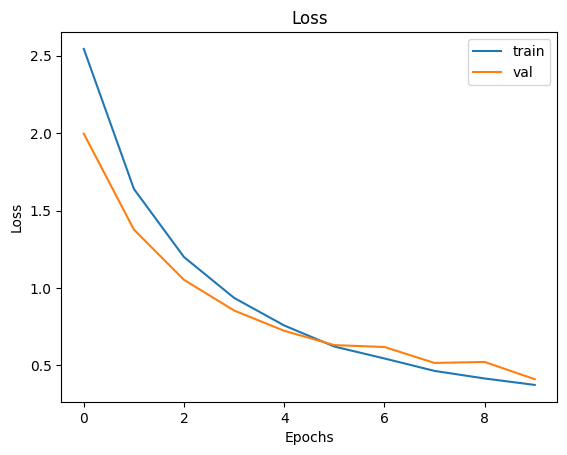

In [20]:
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

Text(0, 0.5, 'Loss')

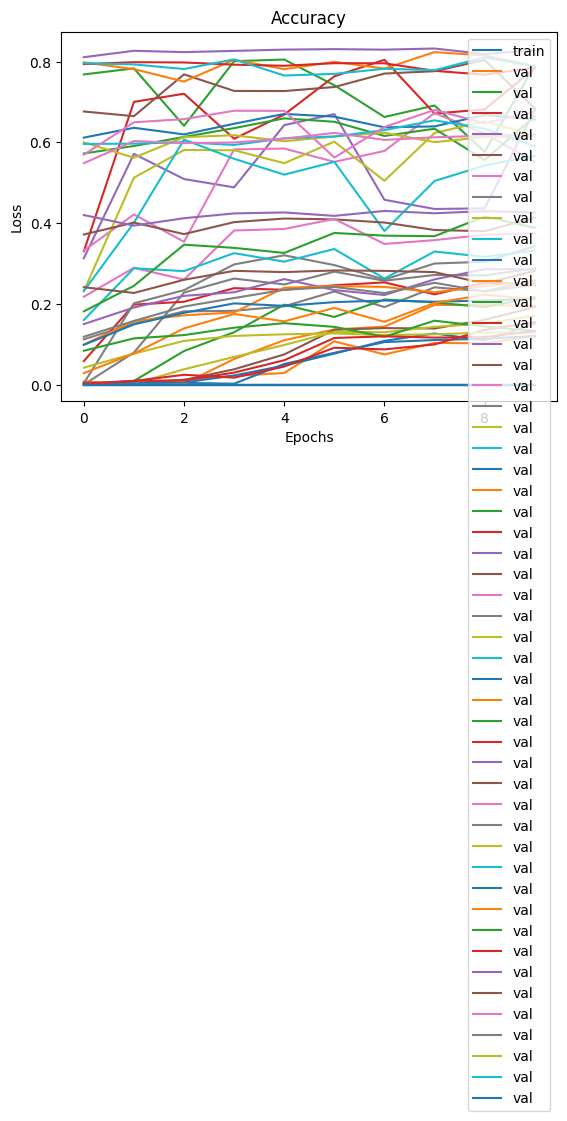

In [21]:
plt.plot(train_accuracies, label="train")
plt.plot(val_accuracies, label="val")
plt.legend()
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [22]:
num_correct = 0
total_guesses = 0

evaluator.eval()
with torch.no_grad():
    for data, targets in iter(val_loader):
        # Sends data and targets to device
        data = data.to(device)
        targets = targets.to(device)

        # Acquires the network's best guesses at each class
        results = evaluator(data)
        best_guesses = torch.argmax(results, 1)

        # Updates number of correct and total guesses
        num_correct += torch.eq(targets, best_guesses).sum().item()
        total_guesses += len(targets)

print("Correctly guessed ", num_correct / total_guesses * 100, "% of the dataset")

Correctly guessed  91.33928571428571 % of the dataset


# Save model

In [ ]:
path = "../models/evaluator.pth"
torch.save(evaluator.state_dict(), path)